Install dependencies

In [ ]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 35.1 MB/s eta 0:00:00


Import required libraries

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ActionChains
import time
from selenium.common.exceptions import NoSuchElementException
import pandas as pd

In [ ]:
# Initialize Chrome WebDriver
options = webdriver.ChromeOptions()

# Keep the browser open after the script finishes
options.add_experimental_option("detach", True)

# Launch Chrome with the specified options
driver = webdriver.Chrome(options=options)

# Open website
driver.get("https://www.cars24.com/")
driver.maximize_window()

# Set an implicit wait (global wait)
driver.implicitly_wait(5)

# Create an explicit wait instance
wait = WebDriverWait(driver, 20)

wait.until(EC.presence_of_element_located((By.XPATH, "//p[text()='Buy used car']"))).click()

wait.until(EC.presence_of_element_located((By.XPATH, "//li[@data-title='Mumbai']"))).click()

# Create ActionChains instance for performing complex user actions
action = ActionChains(driver)

# Select Car Brand (e.g., Maruti)
brand_selection = wait.until(EC.presence_of_element_located(
    (By.XPATH, "//div[@class='styles_brandModel__j_ScD  styles_customScrollbar__r7txj']//p[text()='Maruti']/..//span")
))

driver.execute_script("arguments[0].scrollIntoView(true);", brand_selection)

# Hover over the brand element and click on it
action.move_to_element(brand_selection).click().perform()
time.sleep(2)

prev_location = None

# Dictionaries and lists to store scraped data
Maruti_Suzuki_Cars_Data = {}
car_names = []
make_years = []
fuel_types = []
KMs_driven = []
transmission_types = []
prices = []


# Handle Lazy Loading by Scrolling
while True:

    try:
        driver.execute_script("window.scrollTo(0, 500);")
        element = driver.find_element(By.XPATH, "//div[@style='height: 50px;']")

        location = element.location['y']

        driver.execute_script("arguments[0].scrollIntoView(true);", element)
        time.sleep(1)

        if prev_location == location:
            print("No more new content.")
            break

        prev_location = location

    except NoSuchElementException:
        print("End of scrollable content, No more new content.")
        break

# Extract All Car detail elements
car_eles = wait.until(EC.presence_of_all_elements_located(
    (By.XPATH, "//div[@class='styles_outer__NTVth']")
))

print(f"Total number of car cards found: {len(car_eles)}")


In [ ]:
# Loop through each car element on the page and extract relevant information

for i, car_ele in enumerate(car_eles, start=1):

    try:
        # Extract Car Name and Manufacturing Year
        car_name_make_year_ele = car_ele.find_element(By.XPATH, ".//span[@class='sc-braxZu kjFjan']")
        action.move_to_element(car_name_make_year_ele).perform()
        car_name_make_year = car_name_make_year_ele.text.split(maxsplit=1)
        make_year = car_name_make_year[0]
        car_name = car_name_make_year[1]

        # Store data in respective lists
        car_names.append(car_name)
        make_years.append(make_year)


        # Extract Car Specifications
        km_driven = car_ele.find_element(By.XPATH, ".//ul//div[1]/p").text
        KMs_driven.append(km_driven)

        fuel_type = car_ele.find_element(By.XPATH, ".//ul//div[2]/p").text
        fuel_types.append(fuel_type)

        transmission_type = car_ele.find_element(By.XPATH, ".//ul//div[3]/p").text
        transmission_types.append(transmission_type)

        # Extract Car Price
        price = car_ele.find_element(By.XPATH, ".//p[@class='sc-braxZu cyPhJl']").text
        prices.append(price)

        # Progress Logging
        if len(prices) % 50 == 0:
            print(f"{i}/{len(car_eles)} car listings processed...")

    except Exception as e:
        print(f"Skipping car index {i} due to error: {e}")
        continue


# Combine Data into Dictionary
Maruti_Suzuki_Cars_Data = {
    "Car Name": car_names,
    "KM Driven": KMs_driven,
    "Manufactured Year": make_years,
    "Fuel Type": fuel_types,
    "Transmission": transmission_types,
    "Price": prices
}

# Convert to DataFrame and Save as CSV
df = pd.DataFrame(Maruti_Suzuki_Cars_Data)

# Save scraped data to a CSV file
df.to_csv("Maruti_Suzuki_Cars_Data.csv", index=False, encoding='utf-8-sig')

print("\nData extraction complete!")
print(f"Total cars extracted: {len(df)}")
print("Data saved to 'Maruti_Suzuki_Cars_Data.csv'")

# Close Browser
driver.close()


50/694 car listings processed...
100/694 car listings processed...
150/694 car listings processed...
200/694 car listings processed...
250/694 car listings processed...
300/694 car listings processed...
350/694 car listings processed...
400/694 car listings processed...
450/694 car listings processed...
500/694 car listings processed...
550/694 car listings processed...
600/694 car listings processed...
650/694 car listings processed...

✅ Data extraction complete!
Total cars extracted: 694
Data saved to 'Maruti_Suzuki_Cars_Data.csv'


Data Cleaning

In [17]:
#Importing libraries
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("Maruti_Suzuki_Cars_Data.csv")

# Overview of dataset
print("Initial Shape:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Clean text columns (trim spaces, unify case)
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip()

# Clean up ₹ and commas (keep ₹ symbol)
for col in df.columns:
    if 'price' in col.lower():
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(',', '', regex=True)
            .str.replace('₹', '₹ ', regex=True)
            .str.replace(r'\s+', ' ', regex=True)
            .str.strip()
        )

# Convert other numeric-like columns (except price)
for col in df.columns:
    if 'price' not in col.lower():
        df[col] = pd.to_numeric(df[col], errors='ignore')

# Handle missing values
for col in df.columns:
    if df[col].dtype in [np.float64, np.int64]:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Optional: remove unwanted special characters from text columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.replace(r'[^a-zA-Z0-9₹.,\- ]', '', regex=True)

# Final summary
print("\nCleaned Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nAny Nulls Remaining?:", df.isnull().sum().sum())

# Save cleaned dataset
df.to_csv("Maruti_Suzuki_Cars_Data_Cleaned.csv", index=False)
print("\nCleaned dataset saved as 'Maruti_Suzuki_Cars_Data_Cleaned.csv'")


Initial Shape: (694, 6)

Column Names:
 ['Car Name', 'KM Driven', 'Manufactured Year', 'Fuel Type', 'Transmission', 'Price']

Missing Values:
 Car Name             0
KM Driven            0
Manufactured Year    0
Fuel Type            0
Transmission         0
Price                0
dtype: int64

Cleaned Shape: (694, 6)

Data Types:
 car_name             object
km_driven            object
manufactured_year     int64
fuel_type            object
transmission         object
price                object
dtype: object

Any Nulls Remaining?: 0

Cleaned dataset saved as 'Maruti_Suzuki_Cars_Data_Cleaned.csv'


/tmp/ipython-input-1437135271.py:39: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
/tmp/ipython-input-1437135271.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-1437135271.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an 

Visualize the data from "Maruti_Suzuki_Cars_Data_Cleaned.csv" by creating visualizations to explore the relationships between different features, such as price vs. manufacturing year and price vs. KM driven.

## Load the cleaned data

### Subtask:
Load the `Maruti_Suzuki_Cars_Data_Cleaned.csv` file into a pandas DataFrame.


**Reasoning**:
The subtask is to load the cleaned CSV file into a DataFrame and display its head and info. This can be done in a single code block.



In [18]:
import pandas as pd

df_cleaned = pd.read_csv("Maruti_Suzuki_Cars_Data_Cleaned.csv")
display(df_cleaned.head())
display(df_cleaned.info())

,car_name,km_driven,manufactured_year,fuel_type,transmission,price
0,Maruti Ciaz,8.32k km,2023,Petrol,Auto,₹ 8.15 lakh
1,Maruti Wagon R 1.0,43.42k km,2017,Petrol,Manual,₹ 2.91 lakh
2,Maruti Ritz,99.20k km,2013,Petrol,Manual,₹ 1.65 lakh
3,Maruti FRONX,24.00k km,2023,Petrol,Auto,₹ 8.46 lakh
4,Maruti Ciaz,36.60k km,2022,Petrol,Manual,₹ 6.40 lakh


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   car_name           694 non-null    object
 1   km_driven          694 non-null    object
 2   manufactured_year  694 non-null    int64 
 3   fuel_type          694 non-null    object
 4   transmission       694 non-null    object
 5   price              694 non-null    object
dtypes: int64(1), object(5)
memory usage: 32.7+ KB


None

## Importing visualization libraries

### Subtask:
Import the necessary libraries for plotting, such as `matplotlib.pyplot` and `seaborn`.


**Reasoning**:
Import the necessary libraries for plotting as requested.



In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

## Visualize price vs. manufacturing year

### Subtask:
Create a scatter plot or a similar visualization to show the relationship between the car's manufacturing year and its price.


**Reasoning**:
Create a scatter plot to visualize the relationship between 'manufactured_year' and 'price'.



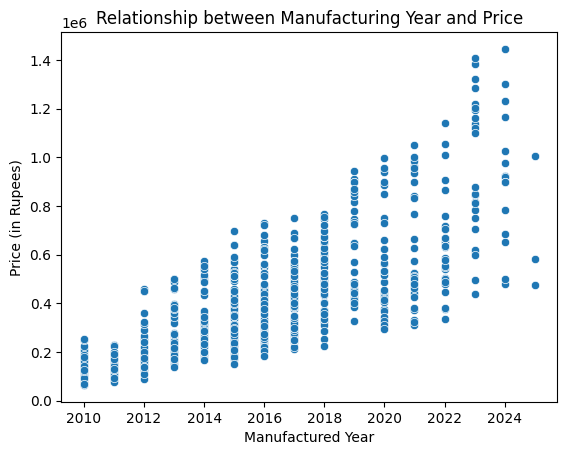

In [20]:
# Convert the 'price' column to a numerical format
df_cleaned['price_numeric'] = df_cleaned['price'].str.replace('₹', '').str.replace(' lakh', 'e5').str.replace(' crore', 'e7').astype(float)

# Create a scatter plot
scatterplot_year_price = sns.scatterplot(x='manufactured_year', y='price_numeric', data=df_cleaned)

# Set plot title and labels
scatterplot_year_price.set_title('Relationship between Manufacturing Year and Price')
scatterplot_year_price.set_xlabel('Manufactured Year')
scatterplot_year_price.set_ylabel('Price (in Rupees)')

# Show the plot
plt.show()

## Visualize price vs. km driven

### Subtask:
Create a scatter plot or a similar visualization to show the relationship between the car's KM driven and its price.


**Reasoning**:
Create a scatter plot to visualize the relationship between KM driven and price.



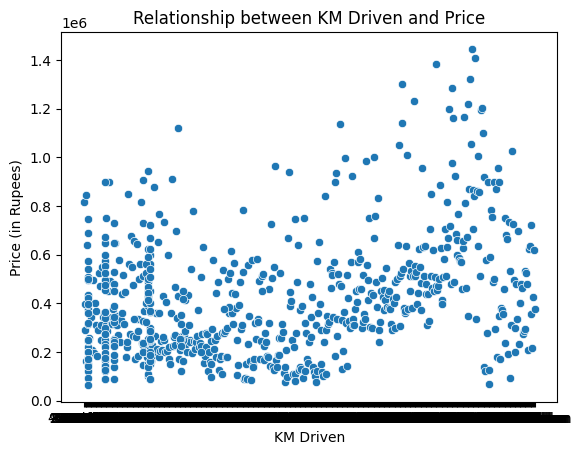

In [21]:
# Create a scatter plot
scatterplot_km_price = sns.scatterplot(x='km_driven', y='price_numeric', data=df_cleaned)

# Set plot title and labels
scatterplot_km_price.set_title('Relationship between KM Driven and Price')
scatterplot_km_price.set_xlabel('KM Driven')
scatterplot_km_price.set_ylabel('Price (in Rupees)')

# Show the plot
plt.show()

## Summary:

### Data Analysis Key Findings

*   A scatter plot was generated to visualize the relationship between the manufacturing year and the price of the cars.
*   A scatter plot was generated to visualize the relationship between the kilometers driven and the price of the cars.

### Insights or Next Steps

*   Examine the scatter plots to identify any clear trends or patterns in the relationship between manufacturing year and price, and between KM driven and price.
*   Consider performing further analysis, such as calculating correlation coefficients, to quantify the strength and direction of these relationships.
